In [1]:
from datetime import datetime, timedelta
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
#read wave wire data
#calculate the mean elevation for each wave wire and each run
#plot fan speed vs. mean elevation, 4 wave wires on each plot
#start time 2020-11-06 17:50:00
#dont use the first minute of each spin up period
#remove the average of the resting wave elevation


In [3]:
"""Reads data from wave wire output file(s) in TOA5 format.
    If filenames is a string, process a single file. If it is
    a list of strings, process files in order and concatenate."""

def read_wavewire_from_toa5(filenames):

    if type(filenames) is str:
        print('Reading ', filenames)
        data = [line.rstrip() for line in open(filenames).readlines()[4:]]
    elif type(filenames) is list:
        
        data = []
        
        for filename in filenames:
            print('Reading ', os.path.basename(filename))
            data += [line.rstrip() for line in open(filename).readlines()[4:]]
    else:
        raise RuntimeError('filenames must be string or list')
    times = []
  
    d = {'w1': [], 'w2': [], 'w3': [], 'w4': [], 'd1': [], 'd2': [], 'd3': [], 'd4': []}
    print('Processing wave wire time series..')
    for line in data:
        line = line.replace('"', '').split(',')
        timestr = line[0]
        #print(line)
        if len(timestr) == 19:
            time = datetime.strptime(timestr, '%Y-%m-%d %H:%M:%S')
        elif len(timestr) == 21:
            time = datetime.strptime(timestr[:19], '%Y-%m-%d %H:%M:%S')
            time += timedelta(seconds=float(timestr[-2:]))
        else:
            time = datetime.strptime(timestr[:19], '%Y-%m-%d %H:%M:%S')
            time += timedelta(seconds=float(timestr[-3:]))
        times.append(time)
        d['w1'].append(float(line[2].strip('"')))
        d['w2'].append(float(line[3].strip('"')))
        d['w3'].append(float(line[4].strip('"')))
        d['w4'].append(float(line[5].strip('"')))
        d['d1'].append(float(line[6].strip('"')))
        d['d2'].append(float(line[7].strip('"')))
        d['d3'].append(float(line[8].strip('"')))
        d['d4'].append(float(line[9].strip('"')))
    for key in d.keys():
        d[key] = np.array(d[key])
    for i in range(1, d[key].size -1, 1):
        if d[key][i] < 0.2:
            d[key][i] = 0.5 * (d[key][i-1] + d[key][i+1])
    return np.array(times), d

In [4]:
#filepath where wave wire data is found
path = '/Users/katie/SUSTAINcode/wave_wires/'
time, elev = read_wavewire_from_toa5([path + "TOA5_OSSwaveX4.elev_26_2020_11_06_1700.dat", path + "TOA5_OSSwaveX4.elev_27_2020_11_06_1800.dat", path + "TOA5_OSSwaveX4.elev_28_2020_11_06_1900.dat"])


Reading  TOA5_OSSwaveX4.elev_26_2020_11_06_1700.dat
Reading  TOA5_OSSwaveX4.elev_27_2020_11_06_1800.dat
Reading  TOA5_OSSwaveX4.elev_28_2020_11_06_1900.dat
Processing wave wire time series..


In [5]:
def TimeIndex(time_dat, year, month, day, hour, minute):
        date_need = datetime(year, month, day, hour, minute, 0)
        diff = abs(time_dat[0]-date_need)
        index = 0
        for i in range (1, len(time_dat) - 1):
            newDiff = abs(time_dat[i]-date_need)
            if (newDiff < diff):
                diff = newDiff
                index = i
        return index

def filtering(wire_dict, time):
    filtered = {}
    for key in wire_dict:
        avg = []
        for test in range(0,11):
            hour = (17 * 60 + 51 + test * 10 ) // 60 #moving to the next Hz and convert to usuable time
            minute = (51 + test * 10 ) % 60
            start = TimeIndex(time, 2020, 11, 6, hour, minute)
            hour = (60 + test * 10 ) // 60
            minute = (60 + test * 10 ) % 60
            end = TimeIndex(time, 2020, 11, 6, 17+ hour, minute)
            #mean = wire_dict[key][start:end][wire_dict[key][start:end] > 0.1].mean() #takes out the values that are bad
            avg.append(np.mean(wire_dict[key][start:end]))
            #avg.append(mean)
        filtered[key] = avg - avg[0] #subtract out the initial height average
    return filtered        

In [6]:
filt_elev = filtering(elev, time)

In [7]:
f_speed = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]) #fan speeds used

Text(0.5, 1.0, 'Fan Speed vs Water Elevation')

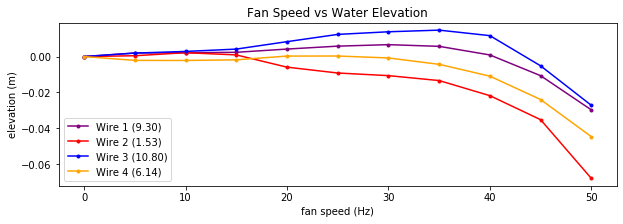

In [8]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(f_speed, filt_elev['w1'], "purple", marker = ".", label = "Wire 1 (9.30)")
plt.plot(f_speed, filt_elev['w2'], "red", marker = ".",label = "Wire 2 (1.53)")
plt.plot(f_speed, filt_elev['w3'], "blue", marker = ".",label = "Wire 3 (10.80)")
plt.plot(f_speed, filt_elev['w4'], "orange",marker = ".", label = "Wire 4 (6.14)")
plt.legend()
plt.xlabel("fan speed (Hz)")
plt.ylabel("elevation (m)")
plt.title("Fan Speed vs Water Elevation")

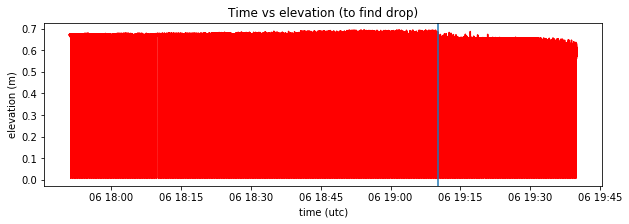

In [9]:
plt.plot(time[61189:191982],elev['w2'][61189:191982], 'red')
plt.xlabel("time (utc)")
plt.ylabel("elevation (m)")
plt.title("Time vs elevation (to find drop)")
plt.axvline(x=time[156220])
#plt.ylim(0.5, 0.75)


drop at  2020-11-06 19:10:14.350000


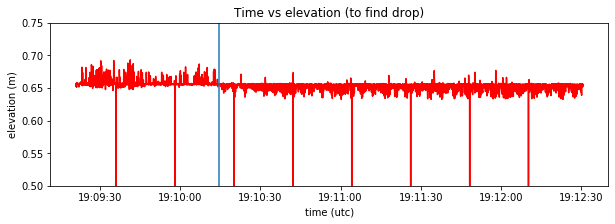

In [10]:
plt.plot(time[155200:159000],elev['w2'][155200:159000], 'red')
plt.axvline(x=time[156270])
plt.ylim(0.5, 0.75)
plt.xlabel("time (utc)")
plt.ylabel("elevation (m)")
plt.title("Time vs elevation (to find drop)")
print("drop at ", time[156270])